In [1]:
!pip install theano
!pip install pymc3
from sklearn.datasets import make_circles,make_moons
import theano
floatX = theano.config.floatX
from pandas import DataFrame
import numpy as np
from sklearn.preprocessing import scale
import pymc3 as pm
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
import theano.tensor as T
import seaborn as sns
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

    100% |████████████████████████████████| 2.8MB 477kB/s 
  Running setup.py bdist_wheel for theano ... - \ | / - \ | / done
  Stored in directory: /content/.cache/pip/wheels/46/a2/7d/b4cac381d5151daa9f9e0b3e4e4b65edaea6355ae296c97cf2
Successfully built theano
    100% |████████████████████████████████| 1.3MB 916kB/s 
    100% |████████████████████████████████| 184kB 4.1MB/s 
    100% |████████████████████████████████| 51kB 10.6MB/s 


/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


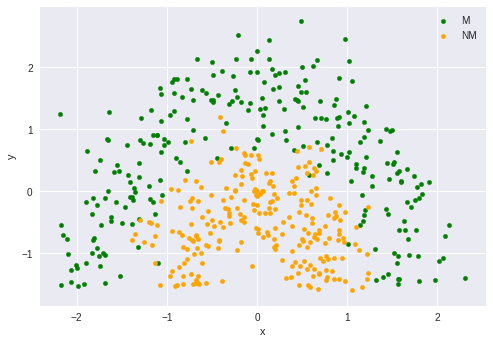

In [4]:
C, D = make_circles(n_samples=1014,noise=0.15, factor=0.5, random_state=1)
testA = []
testB = []

for index, a in np.ndenumerate(C[:,1]):
   if a > 0:
      testA.append(C[index])
      testB.append(D[index])
    
X = np.asarray(testA)
Y = np.asarray(testB)
X = scale(X)
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=Y))
colors = {0:'blue', 1:'red'}
fig, ax = plt.subplots()
names = ["M","NM"]
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=names[key], color=colors[key])
plt.savefig("scatterplotADVI.png",dpi=600)
from google.colab import files
files.download( "scatterplotADVI.png")

In [5]:
X = X.astype(floatX)
Y = Y.astype(floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

500

In [0]:
def construct_nn(ann_input, ann_output):
    n_hidden = 4
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_3 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_out = np.random.randn(n_hidden).astype(floatX)

    with pm.Model() as neural_network:
       
        weights_in_1 = pm.Normal('w_in_1', 0, sd=1,
                                 shape=(X.shape[1], n_hidden),
                                 testval=init_1)

        weights_1_2 = pm.Normal('w_1_2', 0, sd=1,
                                shape=(n_hidden, n_hidden),
                                testval=init_2)
        
        weights_2_3 = pm.Normal('w_2_3', 0, sd=1,
                                shape=(n_hidden, n_hidden),
                                testval=init_2)
       
        weights_2_out = pm.Normal('w_2_out', 0, sd=1,
                                  shape=(n_hidden,),
                                  testval=init_out)

        act_1 = pm.math.tanh(pm.math.dot(ann_input,
                                         weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1,
                                         weights_1_2))
        act_3= pm.math.tanh(pm.math.dot(act_2,
                                         weights_2_3))
        act_out = pm.math.sigmoid(pm.math.dot(act_3,
                                              weights_2_out))
        out = pm.Bernoulli('out',
                           act_out,
                           observed=ann_output,
                           total_size=Y_train.shape[0] 
                          )
    return neural_network

ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)
neural_network = construct_nn(ann_input, ann_output)

In [0]:
from pymc3.theanof import set_tt_rng, MRG_RandomStreams
set_tt_rng(MRG_RandomStreams(42))

In [8]:
%%time

with neural_network:
    inference = pm.ADVI()
    approx = pm.fit(n=50000, method=inference)

Average Loss = 161.49: 100%|██████████| 50000/50000 [01:07<00:00, 746.02it/s]


Finished [100%]: Average Loss = 161.49


CPU times: user 52.4 s, sys: 12.6 s, total: 1min 5s
Wall time: 2min 7s


In [0]:
trace = approx.sample(draws=5000)

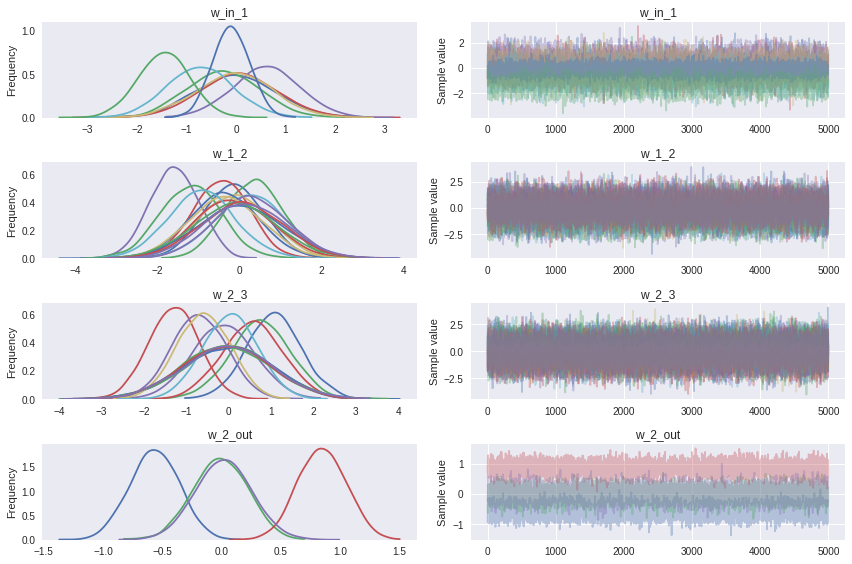

In [10]:
_ = pm.traceplot(trace)
plt.savefig('traceplot.png', dpi=600)
from google.colab import files
files.download( "traceplot.png" )

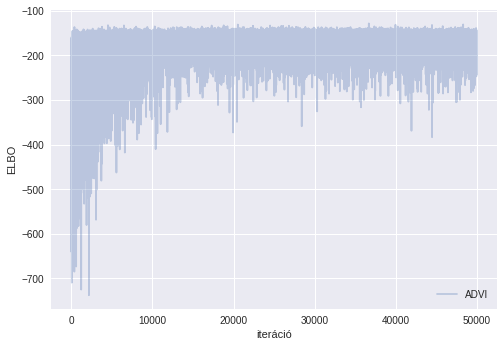

In [11]:
plt.plot(-inference.hist, label='ADVI', alpha=.3)
plt.legend()
plt.ylabel('ELBO')
plt.xlabel('iteráció');
plt.savefig("ELBO.png",dpi=1000)
from google.colab import files
files.download( "ELBO.png")

In [27]:
ann_input.set_value(X_test)
ann_output.set_value(Y_test)

ppc = pm.sample_ppc(trace, model=neural_network, samples=200) 

pred = ppc['out'].mean(axis=0) > 0.5

100%|██████████| 100/100 [00:00<00:00, 1667.56it/s]


[Text(0,0.5,'Y'),
 Text(0.5,0,'X'),
 Text(0.5,1,'Prediktált értékek a teszt halmazon')]

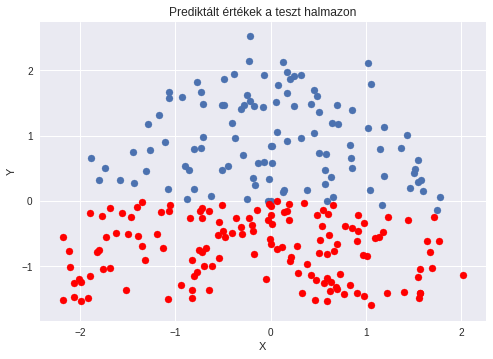

In [13]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
sns.despine()
ax.set(title='Prediktált értékek a teszt halmazon', xlabel='X', ylabel='Y')

In [28]:
print('Accuracy = {}%'.format((Y_test == pred).mean() * 100))

Accuracy = 71.2%


In [0]:
grid = np.mgrid[-3:3:100j,-3:3:100j]
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [99]:
ann_input.set_value(grid_2d)
ann_output.set_value(dummy_out)

ppc = pm.sample_ppc(trace, model=neural_network, samples=500)

100%|██████████| 500/500 [00:02<00:00, 178.96it/s]


Text(0,0.5,'Az 1-es osztályba tartozás posteriori valószínűségei')

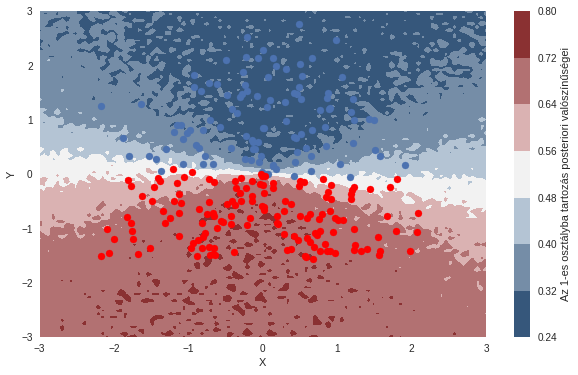

In [107]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(*grid, ppc['out'].mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Az 1-es osztályba tartozás posteriori valószínűségei')

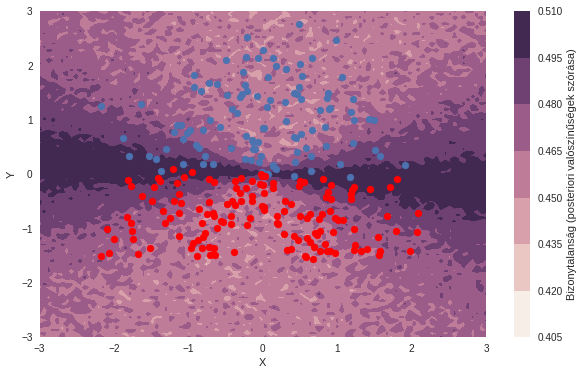

In [110]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(*grid, ppc['out'].std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Bizonytalanság (posteriori valószínűségek szórása)');